# Analyze the data from the experimental campaign

In this notebook we analyze the results generated by launching the experimental campaign `campaign.py`.

## Initializing the environment

Change these variables if needed, to match your settings of the experimental campaign:

In [1]:
from scripts.util import ROOT_DIR
OUT_DIR = f"{ROOT_DIR}/out"         # where the computed stats are
metrics_path = f"{OUT_DIR}/metrics_fullexpe.csv"
rel_metrics_path = f"{OUT_DIR}/metrics_relative_fullexpe.csv"
FIG_DIR =  f"{ROOT_DIR}/out"         # to save a PDF copy of the figures

nb_replicat = 30
save_number=1       # when several expe campaigns, default: leave 0

time_origin_energy = "Jan 1 00:00:00 2019"

Necessary imports, file loads and functions:

In [2]:
from  datetime import datetime,timedelta
import pandas as pd, json, numpy as np
from dateutil import parser
# from scripts.util import *
# from scripts.plot_library import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from scipy.stats import linregress

expe_start_time = parser.parse('Sun Jun  1 00:00:00 CEST 2014').timestamp()
print(f"Expe start timestamp: {expe_start_time}")
with open(f"{OUT_DIR}/expe_done_dict_{save_number}.json") as expe_done_file :
    expe_done_dict =json.load(expe_done_file)
with open(f"{OUT_DIR}/windows_dict_{save_number}.json") as windows_dict_file :
    windows_dict = json.load(windows_dict_file)
    red_windows_dict = windows_dict["red_windows"]
    yellow_windows_dict = windows_dict["yellow_windows"]
red_windows_dict = {int(k): v for k,v in red_windows_dict.items()}
yellow_windows_dict = {int(k) : v for k,v in yellow_windows_dict.items()}
red_windows,yellow_windows = red_windows_dict[0]["_simu_solar_wind"],yellow_windows_dict[0]["_simu_solar_wind"]
print(red_windows_dict,yellow_windows_dict)

def confi_interval(group):
    """Confidence interval 99.7%"""
    return 3 * group.std() / math.sqrt(nb_replicat)

Expe start timestamp: 1401573600.0
{0: {'_simu_solar_wind': [[86400, 104400], [151200, 194400], [237601, 277200], [324000, 367200], [410401, 453600], [496801, 543600], [583201, 622800], [666001, 712800], [756001, 799200], [842401, 889200], [928801, 968400], [1015201, 1062000], [1101601, 1141200], [1188000, 1227600], [1274401, 1317600], [1360801, 1400400], [1447201, 1490400], [1530001, 1573200], [1620001, 1663200], [1706401, 1746000], [1792801, 1832400], [1879200, 1918800], [1969201, 2005200], [2055601, 2091600], [2142001, 2178000], [2224801, 2264400], [2311201, 2350800], [2397601, 2437200], [2484000, 2527200], [2570401, 2610000], [2613601, 2617200], [2656801, 2696400], [2743200, 2786400], [2829601, 2876400], [2912401, 2955600], [3002401, 3042000], [3092401, 3128400], [3178801, 3218400], [3265201, 3301200], [3351601, 3387600], [3438001, 3477600], [3520800, 3564000], [3603600, 3650400], [3697201, 3733200], [3780001, 3823200], [3870001, 3909600], [3952800, 3999600], [4035601, 4082400], [4

## Distribution of window states on a typical week
From the energy data, let's visualize the distribution of window states on a typical week:

/tmp/ipykernel_46880/2940534072.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([beg_short, end_short])


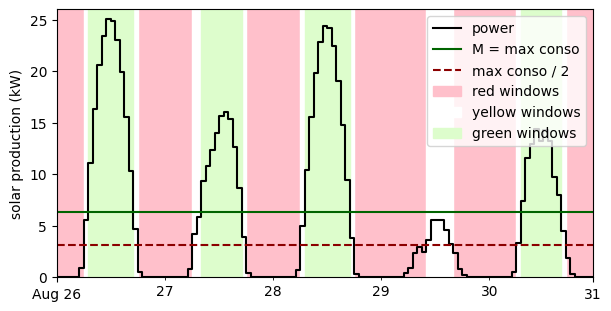

In [3]:
# Import energy datafile
prod = pd.read_csv(f"{ROOT_DIR}/data_energy/energy_trace_sizing_solar.csv")
prod["date"] = pd.to_datetime(prod["time"], unit='s', utc=True, origin=time_origin_energy)
prod.set_index("date", inplace=True)

# Select days to plot
beg, end = "Aug 26 00:00:00 2019", "Aug 31 00:00:00 2019"
beg_short, end_short = "Aug 26", "31"
select = prod[(prod.index >= beg) & (prod.index < end)]

# Plot renewable prod
fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)
select.plot(kind="line", xlabel="", y="power", ylabel="solar production (kW)", color="black", drawstyle="steps-post", ax=ax)

# Display window thresholds
yellow_threshold = 42*150 # 42 servers, 150W max each
red_threshold = yellow_threshold//2
ax.axhline(yellow_threshold, label="M = max conso",color="darkgreen")
ax.axhline(red_threshold, label="max conso / 2",color="darkred",linestyle="dashed")

# Display windows
def plot_window(window_indexes, color, label):
    for x in window_indexes:
        ax.axvspan(xmin=x, xmax=x+pd.Timedelta(1, "h"), color=color, label=label)
        label=None
plot_window(select[select.power <= red_threshold].index, 
    color="pink", label="red windows")
plot_window(select[(select.power > red_threshold) & (select.power <= yellow_threshold)].index,
    color='white', label="yellow windows")
plot_window(select[select.power > yellow_threshold].index,
    color='#DDFDCC', label="green windows")

# Cosmetics
ax.set_ylim(0,26000)
ax.set_yticks(np.arange(0, 30000, step=5000)); ax.set_yticklabels(np.arange(0, 30, step=5))
ax.set_xticklabels([beg_short, end_short])
plt.legend(loc="upper right")
plt.savefig(f"{FIG_DIR}/windows_distrib.pdf", bbox_inches="tight")

Let's look at the length distribution of the window states:

In [4]:
def compute_windows_length_list(window_list) :
    window_length_list =[]
    for window in window_list :
        window_length_list.append(round((window[1]-window[0])/3600))
    return window_length_list
yellow_windows_length = compute_windows_length_list(yellow_windows)
red_windows_length= compute_windows_length_list(red_windows)
yellow_windows_length_df = pd.DataFrame(data=yellow_windows_length)
red_windows_length_df = pd.DataFrame(data=red_windows_length)

print("Distribution analysis of state length (in hours):")
print("Yellow state:")
print(yellow_windows_length_df.value_counts())
print("Red state:")
print(red_windows_length_df.value_counts())
print("Quantiles red state:")
print(red_windows_length_df.quantile([0.1,0.25,0.75,0.9]))

Distribution analysis of state length (in hours):
Yellow state:
1    225
2     29
3      4
6      2
dtype: int64
Red state:
12    53
11    19
13    19
15    18
16    17
14    14
17     8
10     7
1      3
18     3
19     2
5      1
21     1
23     1
dtype: int64
Quantiles red state:
         0
0.10  11.0
0.25  12.0
0.75  15.0
0.90  16.0


In [5]:
print("\nMax length of windows (in hours) : ")
print(f"    Yellow state: {yellow_windows_length_df.max()[0]}")
print(f"    Red state:    {red_windows_length_df.max()[0]}")

print("\nTotal window duration (in hours) :")
print(f"    Yellow state: {yellow_windows_length_df.sum()[0]}")
print(f"    Red state:    {red_windows_length_df.sum()[0]}")


Max length of windows (in hours) : 
    Yellow state: 6
    Red state:    23

Total window duration (in hours) :
    Yellow state: 307
    Red state:    2180


Let's compute the state distribution in  function of the time of the day.

    hour  red  yellow  green
0      0  162       0      0
1      1  162       0      0
2      2  162       0      0
3      3  162       0      0
4      4  162       0      0
5      5  137      25      0
6      6   65      53     44
7      7   17      43    102
8      8    9      16    137
9      9    2      10    150
10    10    3       8    151
11    11    2       6    154
12    12    3       9    150
13    13    3      14    145
14    14   10      21    131
15    15   24      22    116
16    16   49      23     90
17    17   77      56     29
18    18  151      12      0
19    19  162       1      0
20    20  162       1      0
21    21  162       1      0
22    22  162       1      0
23    23  162       1      0
<BarContainer object of 24 artists>
<BarContainer object of 24 artists>
<BarContainer object of 24 artists>


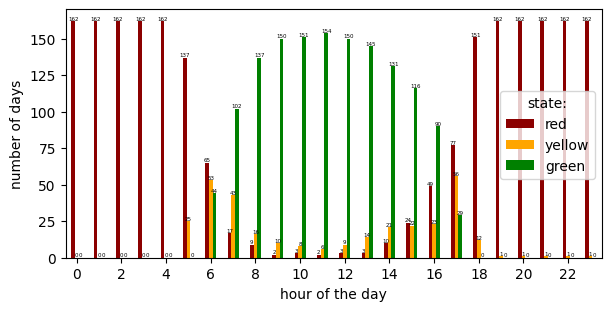

In [6]:
def compute_windows_datetime(window_list,expe_start_timestamp) :
    window_datetime_list =[]
    for window in window_list :
        begin,end = window[0] + expe_start_timestamp, window[1] + expe_start_timestamp
        window_datetime_list.append([datetime.fromtimestamp(begin),datetime.fromtimestamp(end)])
    return window_datetime_list
def compute_windows_hourday(window_list_datetime) :
    window_hourday_list =[]
    for window in window_list_datetime :
        begin = window[0].hour
        end = window[1].hour
        window_hourday_list.append([begin,end])
    return window_hourday_list
def cut_window(window_list,begin_exp,end_exp) :
    for window in window_list :
        window[0] = max(begin_exp,window[0])
        window[1] = min(end_exp,window[1])
def compute_hour_list(hour_window) :
    begin_range = hour_window[0]
    end_range = hour_window[1]
    if hour_window[0] == hour_window[1] :
        end_range+=1
    if hour_window[0] > hour_window[1] :
        end_range = hour_window[1]+24
    hour_list =[]
    for hour in range(begin_range,end_range) :
        hour_list.append(hour%24)
    return hour_list
def compute_hour_list_all(hour_window_list) :
    hour_list = []
    for hour_window in hour_window_list :
        hour_list+=compute_hour_list(hour_window)
    return hour_list

begin_exp = 1*24*3600
end_exp = 163*24*3600+ 3601
cut_window(yellow_windows,begin_exp,end_exp)
cut_window(red_windows,begin_exp,end_exp)
yellow_windows_datetime = compute_windows_datetime(yellow_windows,expe_start_time)
red_windows_datetime = compute_windows_datetime(red_windows,expe_start_time)
yellow_windows_hourday = compute_windows_hourday(yellow_windows_datetime)
red_windows_hourday = compute_windows_hourday(red_windows_datetime)
yellow_hour_list = compute_hour_list_all(yellow_windows_hourday)
yellow_hour_list = yellow_hour_list + [i for i in range(24)]
red_hour_list = compute_hour_list_all(red_windows_hourday)
yellow_windows_hourday_df = pd.DataFrame(data=yellow_hour_list,columns=["hour"])
red_windows_hourday_df = pd.DataFrame(data=red_hour_list,columns=["hour"])
aggregated_red = red_windows_hourday_df.value_counts()
aggregated_red.sort_index(inplace=True)
aggregated_red_df = pd.DataFrame(aggregated_red,columns=["number of windows"])
aggregated_red_df.reset_index(inplace=True)

aggregated_yellow = yellow_windows_hourday_df.value_counts()
aggregated_yellow.sort_index(inplace=True)
aggregated_yellow_df = pd.DataFrame(aggregated_yellow,columns=["number of windows"])
aggregated_yellow_df.reset_index(inplace=True)
aggregated_yellow_df["number of windows"]-=1
aggregated_green_df = aggregated_red_df.copy()
aggregated_green_df["number of windows"] = 162-(aggregated_red_df["number of windows"] + aggregated_yellow_df["number of windows"])
aggregated_green_df["number of windows"] = np.maximum(0,aggregated_green_df["number of windows"])
aggregated_windows = aggregated_red_df.loc[:,["hour"]]
aggregated_windows["red"] = aggregated_red_df["number of windows"]
aggregated_windows["yellow"] = aggregated_yellow_df["number of windows"]
aggregated_windows["green"] = aggregated_green_df["number of windows"]
print(aggregated_windows)
fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)
aggregated_windows.plot.bar(x="hour",rot=0,ax=ax,color={"red" : "darkred", "yellow" : "orange", "green" : "green" })

# You can comment or uncomment this section to get the number on the bar
for bars in ax.containers:
   ax.bar_label(bars,fontsize=4)
   print(bars)

ax.xaxis.set_ticks(np.arange(0, 24, 2))
ax.xaxis.set_ticklabels(np.arange(0, 24, 2)%24)
plt.legend(title="state:", bbox_to_anchor=(0.5, 0., 0.5, 0.7))
plt.xlabel("hour of the day")
plt.ylabel("number of days")
plt.savefig(f"{FIG_DIR}/stat_windows.pdf", bbox_inches="tight")
plt.show()

## Metrics of all experiments

Let's see what does this file look like:

In [7]:
metrics = pd.read_csv(metrics_path)
display(metrics)

Unnamed: 0  XP                                                dir  \
0             0   0  /home/jogatt/stage-jolyne/save-dir/out/expe0/d...   
1             1   0  /home/jogatt/stage-jolyne/save-dir/out/expe0/d...   
2             2   0  /home/jogatt/stage-jolyne/save-dir/out/expe0/d...   
3             3   0  /home/jogatt/stage-jolyne/save-dir/out/expe0/d...   
4             4   0  /home/jogatt/stage-jolyne/save-dir/out/expe0/d...   
..          ...  ..                                                ...   
239         239   0  /home/jogatt/stage-jolyne/save-dir/out/expe0/d...   
240         240   0  /home/jogatt/stage-jolyne/save-dir/out/expe0/d...   
241         241   0  /home/jogatt/stage-jolyne/save-dir/out/expe0/d...   
242         242   0  /home/jogatt/stage-jolyne/save-dir/out/expe0/d...   
243         243   0  /home/jogatt/stage-jolyne/save-dir/out/expe0/r...   

                                        behavior   #jobs    seed  \
0              dm_user_multi_behavior_big_effort  570005       0   
1              dm_user_multi_behavior_big_effort  569774       1   
2              dm_user_multi_behavior_big_effort  569912       2   
3              dm_user_multi_behavior_big_effort  569662       3   
4              dm_user_multi_behavior_big_effort  569360       4   
..                                           ...     ...     ...   
239  dm_user_multi_behavior_medium_effort_yellow  600961  213020   
240  dm_user_multi_behavior_medium_effort_yellow  601277  213021   
241              dm_user_multi_behavior_reconfig  649480       0   
242               dm_user_multi_behavior_renonce  394094       0   
243                            replay_user_rigid  649480       0   

     Duration_red (seconds)  Duration_yellow (seconds)  \
0                   7847870                    1105066   
1                   7847870                    1105066   
2                   7847870                    1105066   
3                   7847870                    1105066   
4                   7847870                    1105066   
..                      ...                        ...   
239                 7847870                    1105066   
240                 7847870                    1105066   
241                 7847870                    1105066   
242                 7847870                    1105066   
243                 7847870                    1105066   

     Duration_total (seconds)  NRJ_red (Joules)  ...  mean_corrected_wtime  \
0                    13996800      2.702822e+10  ...          11996.698248   
1                    13996800      2.704235e+10  ...          10570.916222   
2                    13996800      2.701490e+10  ...           9431.066887   
3                    13996800      2.698951e+10  ...          10328.101735   
4                    13996800      2.697545e+10  ...          12648.252150   
..                        ...               ...  ...                   ...   
239                  13996800      2.816022e+10  ...          12093.643089   
240                  13996800      2.811065e+10  ...           9831.591329   
241                  13996800      3.040103e+10  ...          10949.847486   
242                  13996800      2.023153e+10  ...          14796.787936   
243                  13996800      3.044820e+10  ...                   NaN   

     max_corrected_wtime  mean_corrected_sdown  max_corrected_sdown  \
0          646009.222222            117.792405         57064.700000   
1          676850.000000            105.654509         60437.200000   
2          689055.000000            107.903784         60362.100000   
3          657852.999999            110.939163         58697.700000   
4          642279.000003            112.736757         60636.400003   
..                   ...                   ...                  ...   
239        663619.000001            104.806675         57903.000000   
240        613274.999999            114.816868         61327.700000   
241        672882.000001  

### Mean user effort metrics
Relatively to the control experiment.

In [8]:
metrics_relative = pd.read_csv(rel_metrics_path)
aggregated_behavior_mean = metrics_relative.groupby(["window_type","behavior","XP"]).mean()
aggregated_behavior_mean = aggregated_behavior_mean.add_suffix("_mean")
aggregated_behavior_accuracy = confi_interval(metrics_relative.groupby(["window_type","behavior","XP"]))
aggregated_behavior_accuracy = aggregated_behavior_accuracy.add_suffix("_accuracy")
aggregated_behavior_mean_accuracy = pd.concat([aggregated_behavior_mean,aggregated_behavior_accuracy],axis=1)
columns_list = ["true_rigid_jobs", "renonce_jobs", "consider_degrad_jobs","reconfig_jobs",'C_you_later_jobs']
columns_list = [name+ suffix for name in columns_list for suffix in ["_mean","_accuracy"] ]
aggregated_behavior_mean_accuracy.loc[:,columns_list]

true_rigid_jobs_mean  \
window_type             behavior                                    XP                         
_simu_solar_wind        dm_user_multi_behavior_big_effort           0             -29.484418   
                        dm_user_multi_behavior_degrad               0             -39.321303   
                        dm_user_multi_behavior_low_effort           0              -9.815663   
                        dm_user_multi_behavior_max_effort           0             -39.321601   
                        dm_user_multi_behavior_medium_effort        0             -19.658737   
                        dm_user_multi_behavior_reconfig             0              -6.310433   
                        dm_user_multi_behavior_renonce              0             -39.321611   
_simu_solar_wind_yellow dm_user_multi_behavior_big_effort_yellow    0             -32.703460   
                        dm_user_multi_behavior_low_effort_yellow    0             -10.905966   
                        dm_user_multi_behavior_max_effort_yellow    0             -43.591468   
                        dm_user_multi_behavior_medium_effort_yellow 0             -21.805342   

                                                                        true_rigid_jobs_accuracy  \
window_type             behavior                                    XP                             
_simu_solar_wind        dm_user_multi_behavior_big_effort           0                   0.020904   
                        dm_user_multi_behavior_degrad               0                        NaN   
                        dm_user_multi_behavior_low_effort           0                   0.017107   
                        dm_user_multi_behavior_max_effort           0                   0.000021   
                        dm_user_multi_behavior_medium_effort        0                   0.028837   
                        dm_user_multi_behavior_reconfig             0                        NaN   
                        dm_user_multi_behavior_renonce              0                        NaN   
_simu_solar_wind_yellow dm_user_multi_behavior_big_effort_yellow    0                   0.023745   
                        dm_user_multi_behavior_low_effort_yellow    0                   0.016434   
                        dm_user_multi_behavior_max_effort_yellow    0                   0.010214   
                        dm_user_multi_behavior_medium_effort_yellow 0                   0.019555   

                                                                        renonce_jobs_mean  \
window_type             behavior                                    XP                      
_simu_solar_wind        dm_user_multi_behavior_big_effort           0           12.281435   
                        dm_user_multi_behavior_degrad               0            0.000000   
                        dm_user_multi_behavior_low_effort           0            3.395522   
                        dm_user_multi_behavior_max_effort           0           18.222881   
                        dm_user_multi_behavior_medium_effort        0            7.449016   
                        dm_user_multi_behavior_reconfig             0            0.000000   
                        dm_user_multi_behavior_renonce              0           39.321611   
_simu_solar_wind_yellow dm_user_multi_behavior_big_effort_yellow    0           12.279100   
                        dm_user_multi_behavior_low_effort_yellow    0            3.410467   
                        dm_user_multi_behavior_max_effort_yellow    0           18.218416   
                        dm_user_multi_behavior_medium_effort_yellow 0            7.450863   

                                                                        renonce_jobs_accuracy  \
window_type             behavior                                    XP                          
_simu_solar_wind        dm_user_multi_behavior_big_effort           0                0.014187   
                     

### Mean energy metrics
In kWh, with confidence interval 99.7% using standard deviation ($3\sigma / \sqrt n$).

In [9]:
metrics = pd.read_csv(metrics_path)
#Convert energy to kwh for better view
metrics["NRJ_red (kwh)"] = metrics["NRJ_red (Joules)"]/3600/1000
metrics["NRJ_total (kwh)"] = metrics["NRJ_total (Joules)"]/3600/1000
metrics["NRJ_yellow (kwh)"] = metrics["NRJ_yellow (Joules)"]/3600/1000
metrics["energy underproduced (kwh)"] = metrics["energy underproduced (Joules)"]/3600/1000
metrics["energy overproduced (kwh)"]= metrics["energy overproduced (Joules)"]/3600/1000
aggregated_energy_mean = metrics.groupby(["window_type","behavior","XP"]).mean()
aggregated_energy_mean = aggregated_energy_mean.add_suffix("_mean")
# accuracy is round up to integer to ease reading
aggregated_energy_accuracy = confi_interval(metrics.groupby(["window_type","behavior","XP"])).apply(np.ceil)
aggregated_energy_accuracy = aggregated_energy_accuracy.add_suffix("_accuracy")
aggregated_energy_mean_accuracy = pd.concat([aggregated_energy_mean,aggregated_energy_accuracy],axis=1)
columns_list = ["NRJ_red (kwh)", "NRJ_yellow (kwh)", "NRJ_total (kwh)","energy underproduced (kwh)",'energy overproduced (kwh)']
columns_list = [name+ suffix for name in columns_list for suffix in ["_mean","_accuracy"] ]
aggregated_energy_mean_accuracy.loc[:,columns_list]

NRJ_red (kwh)_mean  \
window_type             behavior                                    XP                       
_simu_solar_wind        dm_user_multi_behavior_big_effort           0          7503.086017   
                        dm_user_multi_behavior_degrad               0          7213.664085   
                        dm_user_multi_behavior_low_effort           0          8194.074735   
                        dm_user_multi_behavior_max_effort           0          7019.031387   
                        dm_user_multi_behavior_medium_effort        0          7881.703283   
                        dm_user_multi_behavior_reconfig             0          8444.731088   
                        dm_user_multi_behavior_renonce              0          5619.868528   
                        replay_user_rigid                           0          8457.832285   
_simu_solar_wind_yellow dm_user_multi_behavior_big_effort_yellow    0          7421.517262   
                        dm_user_multi_behavior_low_effort_yellow    0          8165.403507   
                        dm_user_multi_behavior_max_effort_yellow    0          6914.665159   
                        dm_user_multi_behavior_medium_effort_yellow 0          7826.659792   

                                                                        NRJ_red (kwh)_accuracy  \
window_type             behavior                                    XP                           
_simu_solar_wind        dm_user_multi_behavior_big_effort           0                      7.0   
                        dm_user_multi_behavior_degrad               0                      NaN   
                        dm_user_multi_behavior_low_effort           0                      4.0   
                        dm_user_multi_behavior_max_effort           0                      8.0   
                        dm_user_multi_behavior_medium_effort        0                      7.0   
                        dm_user_multi_behavior_reconfig             0                      NaN   
                        dm_user_multi_behavior_renonce              0                      NaN   
                        replay_user_rigid                           0                      NaN   
_simu_solar_wind_yellow dm_user_multi_behavior_big_effort_yellow    0                      8.0   
                        dm_user_multi_behavior_low_effort_yellow    0                      6.0   
                        dm_user_multi_behavior_max_effort_yellow    0                      8.0   
                        dm_user_multi_behavior_medium_effort_yellow 0                      7.0   

                                                                        NRJ_yellow (kwh)_mean  \
window_type             behavior                                    XP                          
_simu_solar_wind        dm_user_multi_behavior_big_effort           0             1072.854073   
                        dm_user_multi_behavior_degrad               0             1036.689216   
                        dm_user_multi_behavior_low_effort           0             1124.334183   
                        dm_user_multi_behavior_max_effort           0             1046.528079   
                        dm_user_multi_behavior_medium_effort        0             1098.813792   
                        dm_user_multi_behavior_reconfig             0             1161.352545   
                        dm_user_multi_behavior_renonce              0              944.343888   
                        replay_user_rigid                           0             1145.257863   
_simu_solar_wind_yellow dm_user_multi_behavior_big_effort_yellow    0             1053.319755   
                        dm_user_multi_behavior_low_effort_yellow    0             1119.532479   
                        dm_user_multi_behavior_max_effort_yellow    0             1019.927423   
                        dm_user_multi_behavior_medium_effort_yellow 0             1088.183915   

                       

Let's compute the correlation between effort probability alpha and metric underproduction.

In [10]:
def behavior_to_alpha(behavior):
    if "rigid" in behavior :
        return 0
    if "low_" in behavior :
        return .25
    if "medium_" in behavior :
        return .5
    if "big_" in behavior :
        return .75
    if "max_" in behavior :
        return 1

metrics = pd.read_csv(metrics_path)
metrics["alpha"]=metrics["behavior"].apply(lambda x : behavior_to_alpha(x))
alpha = metrics["alpha"]
underprod = metrics["energy underproduced (Joules)"]

print(f"Pearson correlation coefficients:")
print(f"alpha/underprod: {alpha.corr(underprod)}")
print(f"alpha/red_nrj:   {alpha.corr(metrics['NRJ_red (Joules)'])}")
print(f"alpha/yel_nrj:   {alpha.corr(metrics['NRJ_yellow (Joules)'])}")

Pearson correlation coefficients:
alpha/underprod: -0.9916222045338368
alpha/red_nrj:   -0.9918343217511406
alpha/yel_nrj:   -0.9654034516285591


# Graph of energy and Effort


Let's compute the underproduction in function of modified job percentage.

r-square : 0.9571896031960813
linear regression : -37.700930875883984*X+8252.704793698493

Underproduction in fonction of the number of modified jobs:
(the linear regression doesn't take 'renounce/reconfig/degrad' points into account)


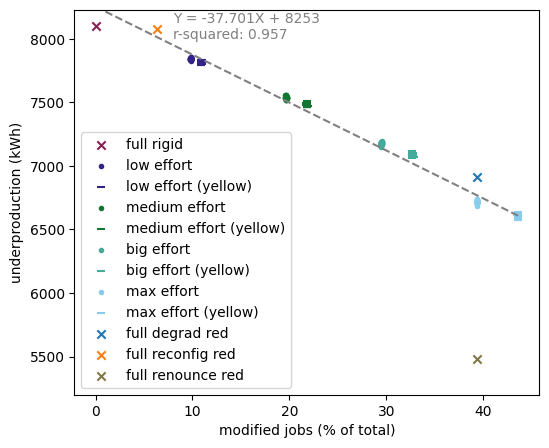

In [11]:
color_blind_map = ["#882255","#332288","#117733","#44AA99","#88CCEE","#827846"]
def color_map(behavior) :
    if "rigid" in behavior :
        return color_blind_map[0]
    if "low_" in behavior :
        return color_blind_map[1]
    if "medium_" in behavior :
        return color_blind_map[2]
    if "big_" in behavior :
        return color_blind_map[3]
    if "max_" in behavior :
        return color_blind_map[4]
    if "renonce" in behavior :
        return color_blind_map[5]
    if "degrad" in behavior :
        return "tab:blue"
    if "reconfig" in behavior :
        return "tab:orange"
    
def marker(behavior) :
    if "yellow" in behavior :
        return "_"
    if ("rigid" in behavior or "renonce" in behavior or 
    "degrad" in behavior or "reconfig" in behavior):
        return "x"
    return "."

def pretty_name(behavior):
    if "rigid" in behavior :
        behavior_name="full rigid"
    elif "renonce" in behavior :
        behavior_name="full renounce red"
    elif "degrad" in behavior :
        behavior_name="full degrad red"
    elif "reconfig" in behavior :
        behavior_name="full reconfig red"
    elif "yellow" in behavior :
        behavior_name=" ".join(behavior.split("_")[-3:-1]) + " (yellow)"
    else :
        behavior_name=" ".join(behavior.split("_")[-2:])

    return behavior_name

def sort_effort(string1) :
    string1 = string1.split("_")
    effort_list = ["rigid","low","medium","big","max","degrad","reconfig","renounce"]
    for index,effort_level in enumerate(effort_list) :
        if effort_level in string1 :
            if "yellow" in string1:
                return index + .5
            else:
                return index
    return len(effort_list)

def plot_energy_fun_effort(energy_metrics_name,effort_metrics_name,metrics,legend_enabled=True,disable_renounce=False,ybot=0,figsize=(6,5)) :
    plt.figure(figsize=figsize)
    ax = plt.gca()

    behavior_list = list(metrics["behavior"].unique())
    behavior_list.sort(key=sort_effort)
    for behavior in behavior_list :
        if disable_renounce and "renonce" in behavior :
            continue
        metrics_sub = metrics[metrics.behavior == behavior]
        marker_value = marker(behavior)
        color_behavior = color_map(behavior)
        behavior_name = pretty_name(behavior)
        ax.scatter(metrics_sub[effort_metrics_name],metrics_sub[energy_metrics_name],
            marker=marker_value,label=behavior_name,color=color_behavior)

    if legend_enabled:
        plt.legend()
    ax.set_ylim(bottom=ybot)
    return ax

metrics = pd.read_csv(metrics_path)

total_jobs = metrics[metrics.behavior=="replay_user_rigid"]["#jobs"].values[0]
# metrics = metrics[metrics.behavior!='dm_user_multi_behavior_degrad']
# metrics = metrics[metrics.behavior!='dm_user_multi_behavior_reconfig']

# Unit conversion...
metrics["energy underproduced (kwh)"] = metrics["energy underproduced (Joules)"]/3600/1000
metrics["unmodified jobs percentage"] = metrics["true_rigid_jobs"]/total_jobs *100
metrics["modified jobs percentage"] = 100 - metrics["unmodified jobs percentage"]
metrics["modified jobs percentage"] = metrics["modified jobs percentage"].fillna(0)

# Plot 
plot_energy_fun_effort("energy underproduced (kwh)","modified jobs percentage",metrics,
    legend_enabled=True,disable_renounce=False,ybot=5200)
plt.xlabel("modified jobs (% of total)")
plt.ylabel("underproduction (kWh)")

# Computation of linear regression
# Sort out renounce before regression
selection_for_regression = metrics[
    (metrics.behavior!="dm_user_multi_behavior_degrad") &
    (metrics.behavior!="dm_user_multi_behavior_reconfig") & 
    (metrics.behavior!="dm_user_multi_behavior_renounce")].copy()
X = selection_for_regression["modified jobs percentage"]
Y = selection_for_regression["energy underproduced (kwh)"]
slope, intercept, r_value, _, _ = linregress(X,Y)

print(f"r-square : {r_value**2}")
print(f"linear regression : {slope}*X+{intercept}")
print("\nUnderproduction in fonction of the number of modified jobs:")
print("(the linear regression doesn't take 'renounce/reconfig/degrad' points into account)")
X = np.linspace(0, max(X))
plt.plot(X,slope*X+intercept, '--', color="gray")
plt.text(x=8,y=8000,color="gray",
    s=f"Y = {slope:.3f}X + {intercept:.0f}\nr-squared: {r_value**2:.3f}")
plt.savefig(f"{FIG_DIR}/underprod_VS_modified_jobs.pdf", bbox_inches="tight")
plt.show()

Computation of quotient between underproduction gains (compared to rigid) and "effort" (percentage of modified jobs) to get an idea of the marginal cost of the gains:

/home/mael/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


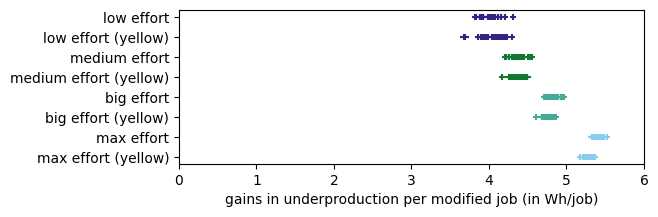

In [12]:
metrics_rigid = metrics[metrics.behavior=="replay_user_rigid"]

# Sort out the experiments we don't need
selection = metrics[
    (metrics.behavior!="replay_user_rigid") & 
    (metrics.behavior!="dm_user_multi_behavior_degrad") &
    (metrics.behavior!="dm_user_multi_behavior_reconfig") & 
    (metrics.behavior!="dm_user_multi_behavior_renonce")].copy()

selection["pretty name"] = selection["behavior"].apply(lambda x : pretty_name(x))
max_energy = metrics_rigid["energy underproduced (kwh)"].values[0]

# Gains in energy underproduced compared to rigid
selection["gains underproduced"] = max_energy - selection["energy underproduced (kwh)"]
selection["modified jobs"] = total_jobs - metrics["true_rigid_jobs"]
selection["energy_quotient"] = selection["gains underproduced"] * 1000 / selection["modified jobs"]

# plot
fig, ax = plt.subplots(figsize=(6,2))
selection["sort_order"] = selection["behavior"].apply(lambda x : sort_effort(x))
selection["color"] = selection["behavior"].apply(lambda x : color_map(x))
selection.sort_values(by='sort_order', ascending=False, inplace=True)
selection.plot.scatter("energy_quotient","pretty name",
    xlabel="gains in underproduction per modified job (in Wh/job)",
    ylabel="", marker="+", color=selection["color"], alpha=1, ax=ax)
ax.set_xlim(0,6)

plt.savefig(f"{FIG_DIR}/ratio_gains_modified_jobs.pdf", bbox_inches="tight")
plt.show()

### Weighted effort

We see that we are near linear. Let's compute underproduction in function of a pondered effort so that renounce jobs
have more weight than see_you_later one :

In [13]:
weight = {
    "reconfig":     1/4,
    "C_you_later":  2/4,
    "degrad":       3/4,
    "renounce":     4/4
}

metrics = pd.read_csv(metrics_path)
# Sort out the experiments we don't need
# metrics = metrics[metrics.behavior!='dm_user_multi_behavior_degrad']
# metrics = metrics[metrics.behavior!='dm_user_multi_behavior_reconfig']
# metrics=metrics[metrics.behavior!="dm_user_multi_behavior_renonce"]

total_jobs = metrics[metrics.behavior=="replay_user_rigid"]["#jobs"].values[0]
metrics["pretty name"] = metrics["behavior"].apply(lambda x : pretty_name(x))

metrics["weighted_effort"] = (metrics["renonce_jobs"] * weight["renounce"] + 
    metrics["consider_degrad_jobs"] * weight["degrad"] + 
    metrics["reconfig_jobs"]  *weight["reconfig"] + 
    metrics["number_of_see_you_later"] * weight["C_you_later"] ) / total_jobs * 100
metrics["weighted_effort"] = metrics["weighted_effort"].fillna(0)

aggredated = metrics[["pretty name","weighted_effort"]].groupby("pretty name").agg(["mean",confi_interval])

print("Weighted effort for each expe:")
display(aggredated["weighted_effort"])

Weighted effort for each expe:


mean  confi_interval
pretty name                                      
big effort              27.993175        0.020917
big effort (yellow)     30.293658        0.025879
full degrad red         29.490977             NaN
full reconfig red        1.577608             NaN
full renounce red       39.321611             NaN
full rigid               0.000000             NaN
low effort               7.759204        0.013027
low effort (yellow)      8.513093        0.015404
max effort              41.509769        0.020746
max effort (yellow)     44.647972        0.016775
medium effort           16.966042        0.025738
medium effort (yellow)  18.471296        0.017461


Underproduction in fonction of weighted user effort:
r-square : 0.965461563762817
linear regression : -33.896612958929346*X+8107.549057879646

Underproduction in fonction of weighted user effort:
(the linear regression doesn't take 'renounce/reconfig/degrad' points into account)


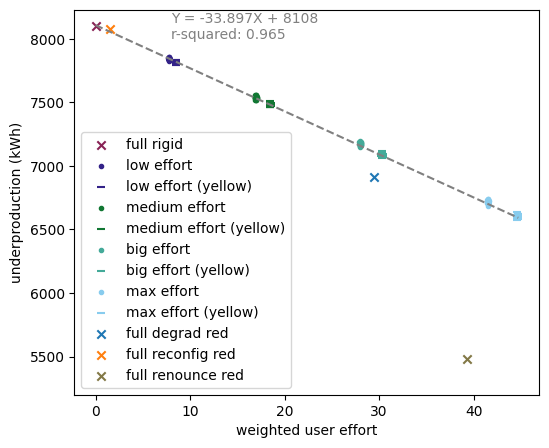

In [14]:
metrics["energy underproduced (kwh)"] = metrics["energy underproduced (Joules)"]/3600/1000

print("\nUnderproduction in fonction of weighted user effort:")
plot_energy_fun_effort("energy underproduced (kwh)","weighted_effort",metrics,
    legend_enabled=True,disable_renounce=False,ybot=5200)
plt.xlabel("weighted user effort")
plt.ylabel("underproduction (kWh)")

# Do the linear regression
# Sort out unwanted behaviors before regression:
selection_for_regression = metrics[
    (metrics.behavior!="dm_user_multi_behavior_degrad") &
    (metrics.behavior!="dm_user_multi_behavior_reconfig") & 
    (metrics.behavior!="dm_user_multi_behavior_renounce")].copy()
X, Y = selection_for_regression["weighted_effort"], selection_for_regression["energy underproduced (kwh)"]
slope, intercept, r_value, _, _ = linregress(X,Y)

print(f"r-square : {r_value**2}")
print(f"linear regression : {slope}*X+{intercept}")
print("\nUnderproduction in fonction of weighted user effort:")
print("(the linear regression doesn't take 'renounce/reconfig/degrad' points into account)")
X = np.linspace(0, max(X))
plt.plot(X,slope*X+intercept, '--', color="gray")
plt.text(x=8,y=8000,color="gray",
    s=f"Y = {slope:.3f}X + {intercept:.0f}\nr-squared: {r_value**2:.3f}")
plt.savefig(f"{FIG_DIR}/underprod_VS_weighted_effort.pdf", bbox_inches="tight")
plt.show()

/home/mael/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


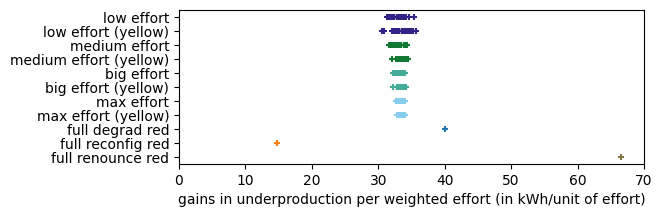

In [15]:
max_energy = metrics[metrics.behavior=="replay_user_rigid"]["energy underproduced (kwh)"].values[0]

# Sort out the experiments we don't need
selection = metrics[
    (metrics.behavior!="replay_user_rigid") 
#    & (metrics.behavior!="dm_user_multi_behavior_degrad")
#    & (metrics.behavior!="dm_user_multi_behavior_reconfig")
#    & (metrics.behavior!="dm_user_multi_behavior_renonce")
].copy()
selection["pretty name"] = selection["behavior"].apply(lambda x : pretty_name(x))

# Gains in energy underproduced compared to rigid
selection["gains underproduced"] = max_energy - selection["energy underproduced (kwh)"]
selection["energy_quotient"] = selection["gains underproduced"] / selection["weighted_effort"]

fig, ax = plt.subplots(figsize=(6,2))
selection["sort_order"] = selection["behavior"].apply(lambda x : sort_effort(x))
selection["color"] = selection["behavior"].apply(lambda x : color_map(x))
selection.sort_values(by='sort_order', ascending=False, inplace=True)
selection.plot.scatter("energy_quotient","pretty name",
    xlabel="gains in underproduction per weighted effort (in kWh/unit of effort)",
    ylabel="", marker="+", c=selection["color"], alpha=1, ax=ax)
ax.set_xlim(0,70)

plt.savefig(f"{FIG_DIR}/ratio_gains_weighted_effort.pdf", bbox_inches="tight")
plt.show()

Correlation between alpha and weighted effort:

In [16]:
def behavior_to_alpha(behavior):
    if "rigid" in behavior :
        return 0
    if "low_" in behavior :
        return .25
    if "medium_" in behavior :
        return .5
    if "big_" in behavior :
        return .75
    if "max_" in behavior :
        return 1

metrics["alpha"]=metrics["behavior"].apply(lambda x : behavior_to_alpha(x))
alpha = metrics["alpha"]
w_effort = metrics["weighted_effort"]

print(f"Pearson correlation coefficients:")
print(f"alpha/w_effort: {alpha.corr(w_effort)}")

Pearson correlation coefficients:
alpha/w_effort: 0.9930736668431336
